# 音声超解像 sampling rete 8000Hz to 16000Hz

In [2]:
import wave
import scipy as sp
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import os
import glob
import torch
from torch import nn

## 補間

In [5]:
from torch.nn import functional as F
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def downsampling(waveform, dr):
    down_waveform = signal.resample(waveform, len(waveform)//dr, t=None, axis=0, window=None, domain='time')
    down_waveform = np.array(down_waveform, dtype=np.int16) # 戻しておかないとすごい音がする
    return  down_waveform  

def sinc(waveform, ur):
    waveform = torch.tensor((waveform/ 32768).tolist()) 
    waveform.to(device)
    upsampler = kazane.Upsample(ur)
    waveform_bi = upsampler(waveform)
    waveform_bi = waveform_bi * 32768
    x_numpy = waveform_bi.to('cpu').detach().numpy()
    x_numpy = x_numpy.astype(np.int16)
    #waveform_bicubic = torch.from_numpy(x_numpy)
    waveform_bicubic = x_numpy
    
    return waveform_bicubic
def bicubic(waveform):
    waveform = torch.tensor([[[(waveform/ 32768).tolist()]]]) 
    waveform.to(device)
    waveform_bi = F.interpolate(waveform, (1,  2 * len(waveform[0][0][0])), mode='bicubic', align_corners=False)
    waveform_bi = waveform_bi * 32768
    x_numpy = waveform_bi.to('cpu').detach().numpy()
    x_numpy = x_numpy.astype(np.int16)
    waveform_bicubic = torch.from_numpy(x_numpy)
    waveform_bicubic = x_numpy[0][0][0]
    
    return waveform_bicubic

## データの読み込み, 前処理

In [6]:
#正解データ(wav_file)
wav_file_HF = sorted(glob.glob('multi_16k_wav/*.wav'))
read_path = '/home/corpus/VCTK-Corpus/wav48/p225/' 
HF_magnitude = []
for i in range(5000):
    with wave.open(wav_file_HF[i]) as wave_file:
    #wave_file = wave.open(wav_file_HF[i], "r")
    #data_wav = np.array(wave_file.get_array_of_samples())
        length = wave_file.getnframes()
        fs = wave_file.getframerate()
        x = wave_file.readframes(wave_file.getnframes())
        wav_x = np.frombuffer(x, dtype= "int16")
        f, t, Zxx = signal.stft(wav_x[:length], fs, nperseg=256, noverlap=64)
        mag = np.log(np.abs(Zxx) +10**(-20)).T
        HF_magnitude.append(mag.tolist())
        if i % 2000 == 0:
            print(i)

0
2000
4000


In [7]:
#入力データ(wav_file)
wav_file_LF = sorted(glob.glob('multi_8k_wav/*.wav'))
LF_magnitude = []
angle = []
for i in range(5000):
    with wave.open(wav_file_LF[i]) as wave_file:
    #wave_file = wave.open(wav_file_LF[i], "r")
    #data_wav = np.array(wave_file.get_array_of_samples())
        length = wave_file.getnframes() * 2
        fs = wave_file.getframerate() * 2
        x = wave_file.readframes(wave_file.getnframes())
        wav_x = np.frombuffer(x, dtype= "int16")
        wav_x = bicubic(wav_x)#16000Hz
        #wav_x = sinc(wav_x, 2)
        f, t, Zxx = signal.stft(wav_x[:length], fs, nperseg=256, noverlap=64)
        mag = np.log(np.abs(Zxx) +10**(-20)).T
        LF_magnitude.append(mag.tolist())
        angle.append(np.angle(Zxx))
        if i % 2000 == 0:
            print(i)

0
2000
4000


In [8]:
sp_size = len(LF_magnitude[0][0])
ur = 2
x_train = []
k = 0
time_size = 32
shift = 16
tdata_size = 4500
for data in LF_magnitude[0: tdata_size]:
    k += 1
    if k%2000 == 0:
        print(k)
    i = 0
    while i < len(data)-time_size:
        spg = np.array(data)[i:i + time_size, 0:sp_size//ur]
        x_train.append(spg.tolist())
        i += shift
    spg = np.array(data)[-time_size:, 0:sp_size//ur]
    x_train.append(spg.tolist()) 
    
y_train = []
for data in HF_magnitude[0: tdata_size]:
    i = 0
    while i < len(data)-time_size:
        spg = np.array(data)[i:i + time_size, sp_size//ur:]
        y_train.append(spg.tolist())
        i += shift
    spg = np.array(data)[-time_size:, sp_size//ur:]
    y_train.append(spg.tolist()) 

x_valid = []
for data in LF_magnitude[tdata_size:]:
    i = 0
    while i < len(data)-time_size:
        spg = np.array(data)[i:i + time_size, 0:sp_size//ur]
        x_valid.append(spg.tolist())
        i += shift
    spg = np.array(data)[-time_size:, 0:sp_size//ur]
    x_valid.append(spg.tolist()) 

y_valid = []
for data in HF_magnitude[tdata_size:]:
    i = 0
    while i < len(data)-time_size:
        spg = np.array(data)[i:i + time_size, sp_size//ur:]
        y_valid.append(spg.tolist())
        i += shift
    spg = np.array(data)[-time_size:, sp_size//ur:]
    y_valid.append(spg.tolist()) 

2000
4000


## DataLoader

In [10]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
class AudioDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X # 入力
        self.t = Y # 出力

    def __len__(self):
        return len(self.t) # データ数を返す

    def __getitem__(self, index):
        # index番目の入出力ペアを返す
        return self.X[index].to(device), self.t[index].to(device)

In [12]:
train_dataset = AudioDataset(torch.tensor(x_train), torch.tensor(y_train))
valid_dataset = AudioDataset(torch.tensor(x_valid), torch.tensor(y_valid))

In [13]:
len(train_dataset)

80296

In [14]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

## モデルの定義

In [15]:
ngf = 64

kernel_size = (2, 4) 
class Generator(nn.Module):
    def __init__(self, in_size, out_size, middle_size):
        super(Generator, self).__init__()
        self.input = nn.Linear(in_size, middle_size)
        self.middle = nn.Linear(middle_size, middle_size)
        self.output = nn.Linear(middle_size, out_size)
        self.bn = nn.BatchNorm1d(num_features=middle_size)
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.main = nn.Sequential(
            # 入力は (NC) x 32 x 64
            nn.Conv2d(1, ngf, (2, 4), 2, (kernel_size[0]//2, kernel_size[1]//2), bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ：(ndf) x 16 x 32
            nn.Conv2d(ngf, ngf * 2, (2, 4), 2, (kernel_size[0]//2, kernel_size[1]//2), bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ： (ndf*2) x 8 x 16
            nn.Conv2d(ngf * 2, ngf * 4, (2, 4), 2, (kernel_size[0]//2, kernel_size[1]//2), bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ： (ndf*2) x 4 x 8
            
            
#             nn.ConvTranspose2d( 1, ngf * 8, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(True),
            # サイズ：(ngf*8) x 4 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, (2, 4), 2, (kernel_size[0]//2, kernel_size[1]//2), bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ：(ngf*4) x 8 x 16
            nn.ConvTranspose2d( ngf * 2, ngf , (2, 4), 2, (kernel_size[0]//2, kernel_size[1]//2), bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ：(ngf*2) x 16 x 32
            nn.ConvTranspose2d( ngf , 1, (2, 4), 2, (kernel_size[0]//2, kernel_size[1]//2), bias=False),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ： (nc) x 32 x 64
            nn.Flatten(),
            nn.Linear(1508, 32 * 65),
            
        )
    def forward(self, x):
        x = x.unsqueeze(dim=1)
        out = self.main(x)
        out = torch.reshape(out, (out.shape[0], 32, 65))
        return out

In [16]:
d_kernel_size = (3, 7)
ndf = 64
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #self.linear_in = nn.Linear(256, )
        #入力32*65
        self.conv1 = nn.Conv2d(1, ndf, (3, 7), 2, (d_kernel_size[0]//2, d_kernel_size[1]//2))
        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(ndf, ndf*2, (3, 7), 2, (d_kernel_size[0]//2, d_kernel_size[1]//2))
        self.conv3 = nn.Conv2d(ndf*2, ndf*4, (3, 7), 2, (d_kernel_size[0]//2, d_kernel_size[1]//2))
        self.conv4 = nn.Conv2d(ndf*4, 1, (3, 7), 2, (d_kernel_size[0]//2, d_kernel_size[1]//2))
        self.flat = nn.Flatten()
        self.linear_out = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = x.unsqueeze(dim=1)
        #32*64
        d1 = self.leakyrelu(self.conv1(x))
        #16*32
        d2 = self.leakyrelu(self.conv2(d1))
        #8*16
        d3 = self.leakyrelu(self.conv3(d2))
        d4 = self.leakyrelu(self.conv4(d3))
        #print(x.shape)
        x = self.flat(d4)
        x = x.squeeze()
        x = self.linear_out(x)
        return [d1, d2, d3, d4] ,x

In [17]:

def train_and_valid(train_dataloader, valid_dataloader, model, loss_fn, optimizer, max_epoch):
    loss_train_list = []
    loss_valid_list = []
    for epoch in range(max_epoch):
        s = time.time()#計測開始
        #size = len(X_train)
        loss_train = 0
        total = 0
        for i, (X, y) in enumerate(train_dataloader):
            model.train()
            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
            total += len(X)
        loss_train = loss_train / total
        loss_train_list.append(loss_train)
        
        model.eval()
        loss_valid=0
        total = 0
        with torch.no_grad():
            for i, (X, y) in enumerate(valid_dataloader):
                pred = model(X)
                loss = loss_fn(pred, y)
                loss_valid += loss.item()
                total += len(X)
            loss_valid = loss_valid / total
            loss_valid_list.append(loss_valid)
        e = time.time()
        print('epoch:{3} time:{0} \n train_loss:{1} valid_loss:{2}'.format(e-s, loss_train, loss_valid, epoch))
    train_log = loss_train_list
    valid_log = loss_valid_list
    return train_log, valid_log

In [18]:
# カスタムの重み初期化用関数。netGとnetDで呼び出される
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [19]:
device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
batch_size = 64
in_size = sp_size//ur
out_size = sp_size - sp_size//ur

netG = Generator(in_size, out_size, 2048)
netG.apply(weights_init)
netG.to(device)

print(netG)

Generator(
  (input): Linear(in_features=64, out_features=2048, bias=True)
  (middle): Linear(in_features=2048, out_features=2048, bias=True)
  (output): Linear(in_features=2048, out_features=65, bias=True)
  (bn): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leakyrelu): LeakyReLU(negative_slope=0.2)
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(2, 4), stride=(2, 2), padding=(1, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(2, 4), stride=(2, 2), padding=(1, 2), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(2, 4), stride=(2, 2), padding=(1, 2), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): ConvTranspose2d(256, 128,

In [20]:
# 識別器を作成する
netD = Discriminator()

# weights_init関数を適用して、mean=0, stdev=0.2になるようすべての重みをランダムに初期化する
netD.apply(weights_init)

netD.to(device)

# モデルをprint出力する
print(netD)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(3, 7), stride=(2, 2), padding=(1, 3))
  (leakyrelu): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 7), stride=(2, 2), padding=(1, 3))
  (conv3): Conv2d(128, 256, kernel_size=(3, 7), stride=(2, 2), padding=(1, 3))
  (conv4): Conv2d(256, 1, kernel_size=(3, 7), stride=(2, 2), padding=(1, 3))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear_out): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [67]:
torch.cuda.is_available()

True

In [21]:
#先に生成器を学習
batch_size = 64
max_epoch = 3
optimizer = torch.optim.Adam(netG.parameters(), lr=1e-5)
optimizer.zero_grad()
loss_fn = nn.MSELoss()

## Generatorのみを学習

In [48]:
import time
train_log, valid_log = train_and_valid(train_dataloader, valid_dataloader, netG, loss_fn, optimizer, max_epoch)

epoch:0 time:10.666195392608643 
 train_loss:0.021908007602987625 valid_loss:0.02303762318338137
epoch:1 time:11.22282600402832 
 train_loss:0.02007556325267294 valid_loss:0.02228046651508073
epoch:2 time:11.447274923324585 
 train_loss:0.01893508520403789 valid_loss:0.021273403341403787


In [22]:
num_epochs = 5
batch_size = 64
# BCELoss関数の初期化
criterion = nn.BCELoss()
mse = nn.MSELoss()
l1 = nn.L1Loss()
#criterion_G = nn.BCELoss() + nn.MSELoss()
lr = 0.0002
lrG = 10**(-5)
lrD = 1.0 * 10**(-5)
beta1 = 0.5

# GとDの両方にオプティマイザ：Adamを設定する
optimizerD = torch.optim.Adam(netD.parameters(), lr=lrG, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lrD, betas=(beta1, 0.999))

## GANによる学習

In [36]:
# 訓練のループ

# 訓練の進捗状況を把握するためのリスト

G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# 各エポックについて
for epoch in range(num_epochs):
    # dataloader内の各バッチについて
    for i, (X, y) in enumerate(train_dataloader):
        
        ############################
        #  (1) 識別器Dのネットワーク更新: maximize log(D(x)+ log(1 - D(G(z)) )
        ###########################
        ## 本物画像のバッチを使った訓練
        netD.zero_grad()
        # バッチの形式をランタイムに合わせる
        #real_cpu = y #y_train
        label = torch.ones((X.shape[0], 1)).to(device)
        #torch.full((b_size,), real_label, dtype=torch.float, device=device) #label = 1 np.ones(batch_size)
        # 本物画像のバッチをDに順伝播させる
        _, output = netD(y) #0か1を予測
        # 全ての本物画像のバッチの損失を計算する
        errD_real = criterion(output, label) #答え合わせ
        # 逆伝播で勾配を計算する
        errD_real.backward(retain_graph=True)
        D_x = output.mean().item()

        ## 偽物画像のバッチを使った訓練
        
        # Gを使って、偽画像のバッチを生成
        fake = netG(X) #低解像度を入力
        label = torch.zeros((X.shape[0], 1)).to(device)
        # Dを使って、全ての偽画像を分類
        _, output = netD(fake) #0か1
        
        # 全ての偽画像に対するDの損失を計算
        errD_fake = criterion(output, label)
        # 偽画像に対する勾配を計算
        errD_fake.backward(retain_graph=True)
        D_G_z1 = output.mean().item()
        
        
        # 全ての本物画像のバッチの勾配と、全ての偽画像のバッチの勾配を足す
        errD = errD_real + errD_fake
        
        
        # Dのパラメータを更新
        optimizerD.step()

        ############################
        # (2) 生成器Gのネットワークを更新: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label = torch.ones((X.shape[0], 1)).to(device) #Dが間違えたら損失が減るように
        # ちょうど識別器Dを更新したので、偽画像バッチをもう一度識別器Dに順伝播させる
        fake_features, output = netD(fake)
        real_features, _ = netD(y)
        feature_loss = 0
        for n in range(len(fake_features)):
            feature_loss += l1(fake_features[n], real_features[n])
        # この出力に対するGの損失をもう一度計算
        bce_loss = criterion(output, label)
        mse_loss = mse(output, label)
        errG = bce_loss + 0.33 * mse_loss + (1/len(fake_features)) * feature_loss 
        # Gの勾配を計算
        errG.backward(retain_graph=True)
        D_G_z2 = output.mean().item()
        # Gを更新
        optimizerG.step()
        
        # 訓練のステータスを出力
        if i % 400 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(train_dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # あとでプロットするために損失を保存
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        iters += 1

Starting Training Loop...
[1/5][0/1255]	Loss_D: 2.9270	Loss_G: 3.0810	D(x): 0.0607	D(G(z)): 0.0579 / 0.0642
[1/5][400/1255]	Loss_D: 1.6800	Loss_G: 0.6979	D(x): 0.4231	D(G(z)): 0.5580 / 0.5580
[1/5][800/1255]	Loss_D: 1.4856	Loss_G: 0.7968	D(x): 0.4639	D(G(z)): 0.5113 / 0.5099
[1/5][1200/1255]	Loss_D: 1.4499	Loss_G: 0.7930	D(x): 0.4825	D(G(z)): 0.5126 / 0.5110
[2/5][0/1255]	Loss_D: 1.4623	Loss_G: 0.7783	D(x): 0.4810	D(G(z)): 0.5179 / 0.5171
[2/5][400/1255]	Loss_D: 1.4323	Loss_G: 0.7917	D(x): 0.4892	D(G(z)): 0.5117 / 0.5081
[2/5][800/1255]	Loss_D: 1.4168	Loss_G: 0.7734	D(x): 0.4994	D(G(z)): 0.5142 / 0.5163
[2/5][1200/1255]	Loss_D: 1.4062	Loss_G: 0.8101	D(x): 0.4897	D(G(z)): 0.4993 / 0.4992
[3/5][0/1255]	Loss_D: 1.4141	Loss_G: 0.7729	D(x): 0.5126	D(G(z)): 0.5254 / 0.5157
[3/5][400/1255]	Loss_D: 1.4094	Loss_G: 0.8057	D(x): 0.5026	D(G(z)): 0.5121 / 0.5049
[3/5][800/1255]	Loss_D: 1.3956	Loss_G: 0.8380	D(x): 0.4910	D(G(z)): 0.4946 / 0.4911
[3/5][1200/1255]	Loss_D: 1.4075	Loss_G: 0.8720	D(x): 0

In [25]:
def get_spectral(angle_a, abs_a):
    return abs_a * (np.cos(angle_a) + 1j * np.sin(angle_a))

In [70]:
amp = 2 * np.sqrt(2)
pred_spectral=[]
number = 4501
data = LF_magnitude[number]
i = 0
pred_sp = []
while i <= len(data)-time_size:
    input_sp = torch.tensor(data)[i:i+time_size, 0:sp_size//ur]
    input_sp = input_sp.unsqueeze(0)
    output_sp = netG(input_sp.to(device))
    input_sp = input_sp.squeeze().tolist()
    output_sp = output_sp.squeeze().tolist()
    for j in range(time_size):
        sp = input_sp[j] + output_sp[j]
        pred_sp.append(sp)
    i += time_size
    #print(i)
input_sp = torch.tensor(data)[-time_size:, 0:sp_size//ur]
input_sp = input_sp.unsqueeze(0)
output_sp = netG(input_sp.to(device))
input_sp = input_sp.squeeze().tolist()
output_sp = output_sp.squeeze().tolist()
for i in range(len(data)%time_size):
    sp = input_sp[time_size - len(data)%time_size + i] + output_sp[time_size - len(data)%time_size + i]
    pred_sp.append(sp)
num_pred = np.array(pred_sp)
magnitude_spectrogram = np.exp(num_pred.T) 
spectral_dnn= get_spectral(angle[number], magnitude_spectrogram)
spectral_dnn = np.where(np.abs(spectral_dnn) >= amp/10, spectral_dnn, 0)
_, wav_xrec = signal.istft(spectral_dnn, fs, nperseg=256, noverlap=64)
wav_xrec = np.array(wav_xrec, dtype=np.int16) # 戻しておかないとすごい音がする

In [49]:
#予測の平均をとる.
amp = 2 * np.sqrt(2)
pred_spectral=[]
number = 4501
data = LF_magnitude[number]
i = 0
pred_sp = []
input_sp = torch.tensor(data)[i:i+time_size, 0:sp_size//ur]
input_sp = input_sp.unsqueeze(0)
output_sp = netG(input_sp.to(device))
input_sp = input_sp.squeeze().tolist()
output_sp = output_sp.squeeze().tolist()
for j in range(time_size//4):
    sp = input_sp[j] + output_sp[j]
    pred_sp.append(sp)
while i <= len(data)-time_size:
    input_sp = torch.tensor(data)[i:i+time_size, 0:sp_size//ur]
    input_sp = input_sp.unsqueeze(0)
    output_sp = netG(input_sp.to(device))
    input_sp = input_sp.squeeze().tolist()
    output_sp = output_sp.squeeze().tolist()
    for j in range(time_size//2):
        sp = input_sp[j+time_size//4] + output_sp[j+time_size//4]
        pred_sp.append(sp)
    i += time_size//2
#最後
for j in range(time_size//4):
    sp = input_sp[j + 3 * time_size//4] + output_sp[j + 3 * time_size//4]
    pred_sp.append(sp)

input_sp = torch.tensor(data)[-time_size:, 0:sp_size//ur]
input_sp = input_sp.unsqueeze(0)
output_sp = netG(input_sp.to(device))
input_sp = input_sp.squeeze().tolist()
output_sp = output_sp.squeeze().tolist()
for i in range(len(data)%time_size):
    sp = input_sp[time_size - len(data)%time_size + i] + output_sp[time_size - len(data)%time_size + i]
    pred_sp.append(sp)
num_pred = np.array(pred_sp)
magnitude_spectrogram = np.exp(num_pred.T) 
spectral_dnn= get_spectral(angle[number], magnitude_spectrogram)
spectral_dnn = np.where(np.abs(spectral_dnn) >= amp/10, spectral_dnn, 0)
_, wav_xrec = signal.istft(spectral_dnn, fs, nperseg=256, noverlap=64)
wav_xrec = np.array(wav_xrec, dtype=np.int16) # 戻しておかないとすごい音がする

In [50]:
len(data[0])

129

In [ ]:
length = len(wav_xrec)
fs = 16000
time = np.arange(length) / float(fs)
plt.plot(time, wav_xrec[:length])
plt.xlabel('Time [sec]')
plt.ylabel('Signal')
plt.legend(['iSTFT'])

plt.show()

In [ ]:
from scipy.io.wavfile import write
write("gan_wav_8to16_2d.wav", 16000, wav_xrec)

In [65]:
import IPython.display
IPython.display.Audio("gan_wav_8to16_2d.wav")

In [66]:
import IPython.display
IPython.display.Audio(wav_file_HF[number])

In [67]:
import IPython.display
IPython.display.Audio(wav_file_LF[number])

In [56]:
def stft(read_path):
    wave_file = wave.open(read_path, "r")

    amp = 2 * np.sqrt(2)
    length = wave_file.getnframes()
    fs = wave_file.getframerate()
    time = np.arange(length) / float(fs)
    x = wave_file.readframes(wave_file.getnframes())
    wav_x = np.frombuffer(x, dtype= "int16")

    f, t, Zxx = signal.stft(wav_x[:length], fs, nperseg=1024)
    print('フレームレート:{0}'.format(fs))
    plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)
    plt.colorbar()
    plt.title('8000 to 16000')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

In [57]:
def stft_d(read_path):
    wave_file = wave.open(read_path, "r")

    amp = 2 * np.sqrt(2)
    length = wave_file.getnframes()
    fs = wave_file.getframerate()//3
    time = np.arange(length) / float(fs)
    x = wave_file.readframes(length)
    wav_x = np.frombuffer(x, dtype= "int16")
    wav_x = downsampling(wav_x, 3)#16000Hz
    f, t, Zxx = signal.stft(wav_x[:length], fs, nperseg=1024)
    print('フレームレート:{0}'.format(fs))
    plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)
    plt.colorbar()
    plt.title('8000 to 16000')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    return wav_x

フレームレート:16000


<ipython-input-56-cde3d783ace8>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)


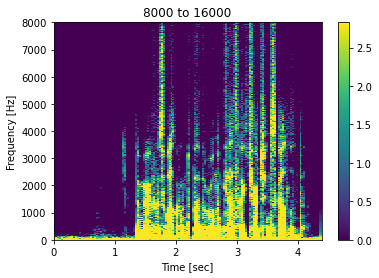

In [68]:
stft("gan_wav_8to16_2d.wav")

フレームレート:16000


<ipython-input-56-cde3d783ace8>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.log(np.abs(Zxx)), vmin=0, vmax=amp)


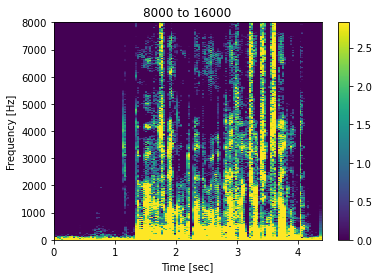

In [59]:
wav_x = stft(wav_file_HF[number])